In [112]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
os.environ["TOKENIZERS_PARALLELISM"] = "false"
load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_KEY")
llm_zero = ChatOpenAI(api_key=OPENAI_KEY,
             temperature=0.5,
             model="gpt-4o-mini-2024-07-18")
llm_few = ChatOpenAI(api_key=OPENAI_KEY,
             temperature=0.5,
             model="gpt-4o-mini-2024-07-18")
llm_fine_tuned = ChatOpenAI(api_key=OPENAI_KEY,
             temperature=0.5,
             model="ft:gpt-4o-mini-2024-07-18:personal:mental-health-4:AabXPYD5")

<h> Goal <h>
<p> The goal of this notebook is to see how similarly the gpt models respond to different inputs from the client therapist database.<p>
<p> The models will be evaluated based on the similarity to how the therapists responded to their clients<p>

In [113]:
import pandas as pd
df = pd.read_csv('./counsel_chat.csv')
print(df.head())

   questionID                              questionTitle  \
0           0  Do I have too many issues for counseling?   
1           0  Do I have too many issues for counseling?   
2           0  Do I have too many issues for counseling?   
3           0  Do I have too many issues for counseling?   
4           0  Do I have too many issues for counseling?   

                                        questionText  \
0  I have so many issues to address. I have a his...   
1  I have so many issues to address. I have a his...   
2  I have so many issues to address. I have a his...   
3  I have so many issues to address. I have a his...   
4  I have so many issues to address. I have a his...   

                                        questionLink       topic  \
0  https://counselchat.com/questions/do-i-have-to...  depression   
1  https://counselchat.com/questions/do-i-have-to...  depression   
2  https://counselchat.com/questions/do-i-have-to...  depression   
3  https://counselchat.com/que

In [114]:
df = df.dropna()
df = df.drop(columns=['questionID', 'questionTitle', 'questionLink', 'therapistInfo', 'topic', 'therapistURL', 'upvotes', 'views'])
df.head()

,questionText,answerText
0,I have so many issues to address. I have a his...,It is very common for people to have multiple ...
1,I have so many issues to address. I have a his...,"I've never heard of someone having ""too many i..."
2,I have so many issues to address. I have a his...,Absolutely not. I strongly recommending worki...
3,I have so many issues to address. I have a his...,Let me start by saying there are never too man...
4,I have so many issues to address. I have a his...,I just want to acknowledge you for the courage...


<p> as we can see above many of the questions have multiple responses, however for the purposes of this project I will be dropping duplicates

In [115]:
df = df.rename(columns={'questionText': 'text', 'answerText': 'response'})

In [116]:
df = df.drop_duplicates(subset='text')
df.head()

,text,response
0,I have so many issues to address. I have a his...,It is very common for people to have multiple ...
86,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically,..."
91,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...
93,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...
96,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...


<h3> Testing

<p> To do this i will test 30 samples for each model to and test on the bertScore model

In [117]:
# example from docs
from evaluate import load
bertscore = load("bertscore")
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general kenobi"]
results = bertscore.compute(predictions=predictions, references=references, lang="en")
print(results)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9999997615814209, 1.000000238418579], 'recall': [0.9999997615814209, 1.000000238418579], 'f1': [0.9999997615814209, 1.000000238418579], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.46.2)'}


In [118]:
from langchain_core.prompts.chat import ChatPromptTemplate

# Define the prompt template
prompt_template = ChatPromptTemplate.from_template("Respond to the following text: {text}")

# Get the first 30 samples
samples = df.head(75)

# Store the responses
responses = []

for index, row in samples.iterrows():
    prompt = prompt_template.format(text=row['text'])
    response = llm_zero(prompt)
    responses.append(response.content)
    print(prompt)

# Evaluate the responses using bertscore
predictions = responses
references = samples['response'].tolist()
results_zero = bertscore.compute(predictions=predictions, references=references, lang="en")

print(results_zero)

Human: Respond to the following text: I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.    I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years.
   I’ve never had counseling about any of this. Do I have too many issues to address in counseling?
Human: Respond to the following text: I have been diagnosed with general anxiety and depression by my family doctor. They wrote a prescription for me to have an emotional support dog, I have the paper work, and I gave it to my apartment manager. They said I can't keep the ESD because I'm not disabled. What do you suggest I do?
Human: Respond to the following text: My mother is combative with me when I say I don't want to talk with her about my depression.    She hasn't been supportive of me in the past and she isn't someone that I feel comfortable opening up to. She constantly tr

In [119]:
print(results_zero["f1"])
print(results_zero["precision"])
print(results_zero["recall"])

[0.8598343729972839, 0.8290223479270935, 0.8231903314590454, 0.8168741464614868, 0.8223158717155457, 0.8019216060638428, 0.842255175113678, 0.8303422927856445, 0.8183850049972534, 0.8438790440559387, 0.840531051158905, 0.8245877623558044, 0.8326554894447327, 0.8383619785308838, 0.8251492381095886, 0.8337610960006714, 0.8452182412147522, 0.8110827207565308, 0.8320865035057068, 0.8436718583106995, 0.8280289769172668, 0.8389894366264343, 0.8565067648887634, 0.8315597772598267, 0.8451524972915649, 0.8207229971885681, 0.8546470403671265, 0.8398312330245972, 0.8512886762619019, 0.824402928352356, 0.8365707993507385, 0.8313823342323303, 0.8531511425971985, 0.8327006697654724, 0.8399001359939575, 0.8502787947654724, 0.8500533699989319, 0.8404588103294373, 0.8481439352035522, 0.8354419469833374, 0.8280980587005615, 0.827781081199646, 0.8298224210739136, 0.8203446269035339, 0.8533332347869873, 0.815807580947876, 0.8217626810073853, 0.8171353936195374, 0.8165157437324524, 0.7966217994689941, 0.83

In [120]:
examples = [
    {
        "question": "Do I have too many issues for counseling?",
        "answer": "It is very common for people to have multiple issues that they want to (and need to) address in counseling.  I have had clients ask that same question and through more exploration, there is often an underlying fear that they can't be helped or that they will be too much for their therapist. I don't know if any of this rings true for you. But, most people have more than one problem in their lives and more often than not,  people have numerous significant stressors in their lives.  Let's face it, life can be complicated! Therapists are completely ready and equipped to handle all of the issues small or large that a client presents in session. Most therapists over the first couple of sessions will help you prioritize the issues you are facing so that you start addressing the issues that are causing you the most distress.  You can never have too many issues to address in counseling.  All of the issues you mention above can be successfully worked through in counseling.",
    },
    {
        "question": "Why do I feel like I don't belong anywhere?",
        "answer": "From the little bit you wrote, my guess is you haven't figured out where and how to lay down your own set of roots.Usually people who have a university level eduction are old enough to work in order to support themselves.Unless you have a medical condition which limits or prevents you from working a full-time job, would you guess that the effort and thought involved in deciding in what professional area and geographic location to look for work, would offer you a way to establish your identity?My suggestion is to pay more attention to your own likes, dislikes, and interests.   To know these areas more deeply would define the type of people with whom you identify, have a common interest and with whom you'd like to socialize.The more you realize who you are, the easier time you'll have to find like-minded others and feel securely at home with them and yourself.Again, if you have a medical disability or condition which prevents employment or easily socializing with other people, then this advice would need to be modified for your specific strengths.",
    },
    {
        "question":"I can't even smile or fake one. I can't feel happiness about anything and I can't show love towards another person not even my girlfriend. I hate myself sometimes. All I see is ugly. I can't get over the loss of a loved one and I'm not close to my family. What can I do?",
        "answer": "Trust and believe your own feelings.Emotions are real and reflect how someone feels about a situation.Since you're sad about losing a loved one, be patient w your feelings about this.  Basically, be guided by how you feel and eventually you will feel different emotions which I hope will be happier ones.",
    },
    {
        "question": "How can I stop treating people badly?",
        "answer": "Give yourself a little more credit for self-observation!You wrote about treating people horribly and not realizing it.  Only if you truly didn't realize what you were doing, then you wouldn't be able to write about it.A little self-examination goes a long way.You have some basic clues about yourself, such as pushing people away whom you love.Start with reflecting on the reasons for your behavior, especially any fears about a negative result from opening your heart to another person.The weird feeling you have is also an area to self-reflect and theorize about.  From what you write, you have a solid awareness of your feelings.  This is the place to start understanding more about your hesitation in relationship with others.  This type of work can be done alone or with a therapist.",
    }
]

In [121]:
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate

# Define the example prompt template
example_prompt = PromptTemplate.from_template("Question: {question}\nAnswer: {answer}")

# Define the prompt template
prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="Question: {text}",
    input_variables=["text"]
)

# Get the first 75 samples
samples = df.head(75)

# Store the responses
responses = []

for index, row in samples.iterrows():
    prompt = prompt_template.format(text=row['text'])
    response = llm_few(prompt)
    responses.append(response.content)

# Evaluate the responses using bertscore
predictions = responses
references = samples['response'].tolist()
results_few = bertscore.compute(predictions=predictions, references=references, lang="en")

print(results_few)

{'precision': [0.8599716424942017, 0.8127722144126892, 0.8033362030982971, 0.8056095838546753, 0.8216626644134521, 0.7921525239944458, 0.8219209313392639, 0.8481354713439941, 0.7943946719169617, 0.8025779724121094, 0.805400013923645, 0.8176136612892151, 0.8124518394470215, 0.8386636972427368, 0.8620426654815674, 0.7805993556976318, 0.846551239490509, 0.8045283555984497, 0.8095084428787231, 0.8716217279434204, 0.8105089068412781, 0.7874278426170349, 0.8376791477203369, 0.8053944706916809, 0.8059277534484863, 0.8193841576576233, 0.8576534986495972, 0.8358368873596191, 0.8121276497840881, 0.8231892585754395, 0.8033544421195984, 0.8407680988311768, 0.8117622137069702, 0.8022124767303467, 0.8038701415061951, 0.8575303554534912, 0.8112729787826538, 0.838375449180603, 0.8381965160369873, 0.8296995759010315, 0.823513388633728, 0.8102595806121826, 0.8507983088493347, 0.8468323945999146, 0.8105135560035706, 0.8430429697036743, 0.8157445192337036, 0.8162996768951416, 0.8022898435592651, 0.7835876

In [123]:
from langchain_core.prompts.chat import ChatPromptTemplate

# Define the prompt template
prompt_template = ChatPromptTemplate.from_template("""{text}""")

# Get the first 75 samples
samples = df.head(75)

# Store the responses
responses = []
references_test = []
i = 0
for index, row in samples.iterrows():
    prompt = prompt_template.format(text=row['text'])
    
    try:
        response = llm_fine_tuned(prompt)
        print(response.content)
        responses.append(response.content)
        # if no exception, add the sample to the references list
        references_test.append(row['response'])
    except Exception as e:
        # remove from the results list of all metrics for other models
        results_zero["f1"][i] = None
        results_zero["precision"][i] = None
        results_zero["recall"][i] = None
        results_few["f1"][i] = None
        results_few["precision"][i] = None
        results_few["recall"][i] = None
        print(f"Error processing sample {index}: {e}")
    i += 1
# Evaluate the responses using bertscore
predictions = responses
references = samples['response'].tolist()
results_fine = bertscore.compute(predictions=predictions, references=references_test, lang="en")

print(results_fine)

I’m not a therapist, but I think that all of these issues are interrelated and that you should look for a therapist who can work with you on all of them. The issues you listed are all significant and I think that they would benefit from a therapist who can give you the time and attention you deserve. 
Emotional support animals (ESAs) are not the same as service animals, which are trained to perform specific tasks for individuals with disabilities. The Americans with Disabilities Act (ADA) does not recognize ESAs as service animals, and therefore, the same protections do not apply. However, some states and local municipalities have laws that provide certain protections for ESAs. You can check with your state or local government to see if there are any laws that provide protections for ESAs. If there are, you may be able to advocate for your ESA under those laws. If there are no laws that protect ESAs in your area, you can still talk to your landlord and explain that your ESA provides yo

In [124]:
print(samples)

                                                  text  \
0    I have so many issues to address. I have a his...   
86   I have been diagnosed with general anxiety and...   
91   My mother is combative with me when I say I do...   
93   There are many people willing to lovingly prov...   
96   My girlfriend just quit drinking and she becam...   
..                                                 ...   
374  I always feel like I'm doing something wrong. ...   
375  I no longer carry expressions on my face, and ...   
377  I'm depressed. I have been for years. I hide i...   
379  He said he would try and he never did. It's be...   
385  I'm in my late 50s. I never loved or have been...   

                                              response  
0    It is very common for people to have multiple ...  
86   This can be a difficult situation.  Typically,...  
91   Do you live with your mom and have constant in...  
93   I truly understand what you are saying. I want...  
96   You're probab

In [125]:
print(results_fine["f1"])
print(results_fine["precision"])
print(results_fine["recall"])

[0.8562929630279541, 0.8557203412055969, 0.8514394164085388, 0.7980874180793762, 0.8020809292793274, 0.79571533203125, 0.8394119143486023, 0.8364160656929016, 0.8341371417045593, 0.8438083529472351, 0.8439599275588989, 0.8444727063179016, 0.8553776144981384, 0.8428252339363098, 0.7810847759246826, 0.8451237082481384, 0.8377525806427002, 0.8534209132194519, 0.82612144947052, 0.8453167080879211, 0.829334020614624, 0.8273496031761169, 0.8401745557785034, 0.8411551117897034, 0.8378767371177673, 0.8301851749420166, 0.8556574583053589, 0.8091410398483276, 0.8458027243614197, 0.8304135203361511, 0.7950683236122131, 0.8171766996383667, 0.8535294532775879, 0.8042603731155396, 0.7984168529510498, 0.8513162136077881, 0.85749751329422, 0.8102529644966125, 0.8513910174369812, 0.8081798553466797, 0.8439351916313171, 0.8211236000061035, 0.8361901640892029, 0.8201065063476562, 0.8407421708106995, 0.8193278908729553, 0.8334758877754211, 0.8299014568328857, 0.7944989204406738, 0.8110462427139282, 0.8333

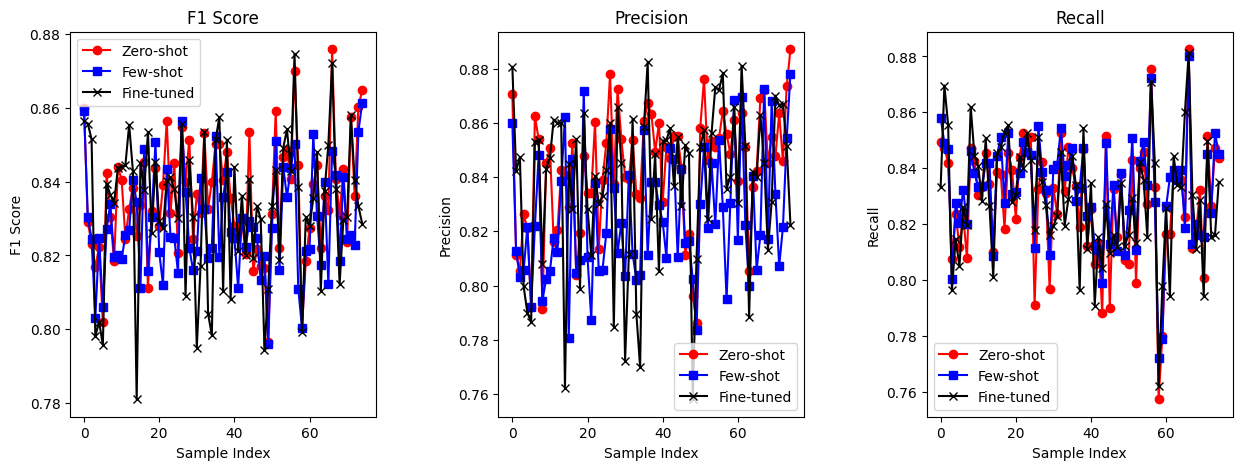

In [138]:
import matplotlib.pyplot as plt
# Set the colors and symbols for the lines
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.4)
colors = ['red', 'blue', 'black']
symbols = ['o', 's', 'x']
f1_zero = results_zero["f1"]
f1_few = results_few["f1"]
f1_fine = results_fine["f1"]
# remove None values
f1_zero = [f1 for f1 in f1_zero if f1 is not None]
f1_few = [f1 for f1 in f1_few if f1 is not None]
f1_fine = [f1 for f1 in f1_fine if f1 is not None]

precision_zero = results_zero["precision"]
precision_few = results_few["precision"]
precision_fine = results_fine["precision"]
# remove None values
precision_zero = [precision for precision in precision_zero if precision is not None]
precision_few = [precision for precision in precision_few if precision is not None]
precision_fine = [precision for precision in precision_fine if precision is not None]

recall_zero = results_zero["recall"]
recall_few = results_few["recall"]
recall_fine = results_fine["recall"]
# remove None values
recall_zero = [recall for recall in recall_zero if recall is not None]
recall_few = [recall for recall in recall_few if recall is not None]
recall_fine = [recall for recall in recall_fine if recall is not None]

# Plot F1 scores
plt.subplot(1, 3, 1)
plt.plot(f1_zero, color=colors[0], marker=symbols[0], label='Zero-shot')
plt.plot(f1_few, color=colors[1], marker=symbols[1], label='Few-shot')
plt.plot(f1_fine, color=colors[2], marker=symbols[2], label='Fine-tuned')
plt.title('F1 Score')
plt.xlabel('Sample Index')
plt.ylabel('F1 Score')
plt.legend()

# Plot Precision scores
plt.subplot(1, 3, 2)
plt.plot(precision_zero, color=colors[0], marker=symbols[0], label='Zero-shot')
plt.plot(precision_few, color=colors[1], marker=symbols[1], label='Few-shot')
plt.plot(precision_fine, color=colors[2], marker=symbols[2], label='Fine-tuned')
plt.title('Precision')
plt.xlabel('Sample Index')
plt.ylabel('Precision')
plt.legend()

# Plot Recall scores
plt.subplot(1, 3, 3)
plt.plot(recall_zero, color=colors[0], marker=symbols[0], label='Zero-shot')
plt.plot(recall_few, color=colors[1], marker=symbols[1], label='Few-shot')
plt.plot(recall_fine, color=colors[2], marker=symbols[2], label='Fine-tuned')
plt.title('Recall')
plt.xlabel('Sample Index')
plt.ylabel('Recall')
plt.legend()

plt.show()

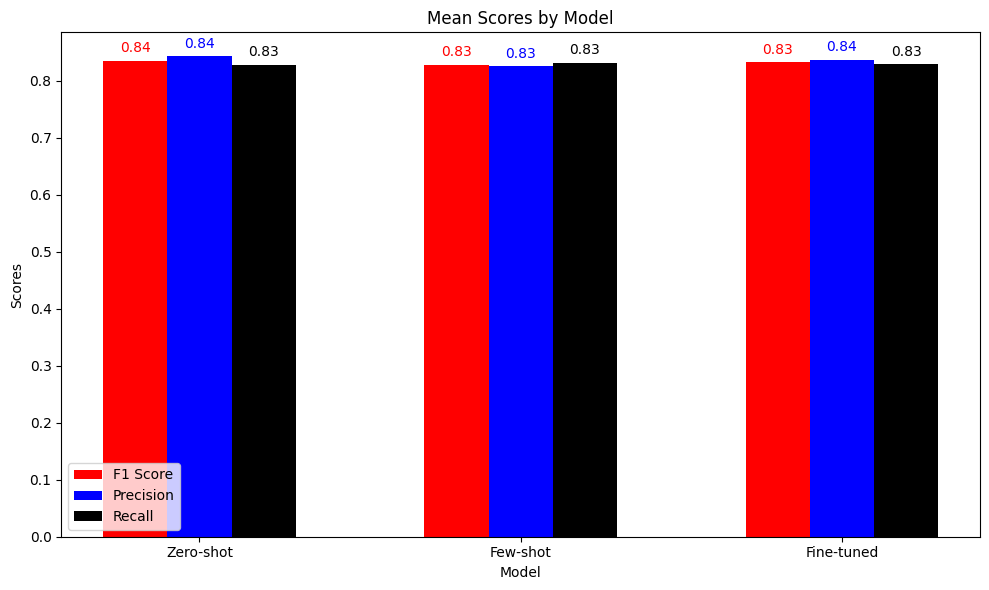

In [139]:
import numpy as np
# Calculate the mean scores for each model
mean_f1_zero = np.mean(f1_zero)
mean_f1_few = np.mean(f1_few)
mean_f1_fine = np.mean(f1_fine)
mean_precision_zero = np.mean(precision_zero)
mean_precision_few = np.mean(precision_few)
mean_precision_fine = np.mean(precision_fine)

mean_recall_zero = np.mean(recall_zero)
mean_recall_few = np.mean(recall_few)
mean_recall_fine = np.mean(recall_fine)

# Plot the mean scores
labels = ['Zero-shot', 'Few-shot', 'Fine-tuned']
f1_means = [mean_f1_zero, mean_f1_few, mean_f1_fine]
precision_means = [mean_precision_zero, mean_precision_few, mean_precision_fine]
recall_means = [mean_recall_zero, mean_recall_few, mean_recall_fine]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, f1_means, width, label='F1 Score', color='red')
rects2 = ax.bar(x, precision_means, width, label='Precision', color='blue')
rects3 = ax.bar(x + width, recall_means, width, label='Recall', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Mean Scores by Model')
for i in range(len(labels)):
    ax.text(x[i] - width, f1_means[i] + 0.01, f'{f1_means[i]:.2f}', ha='center', va='bottom', color='red')
    ax.text(x[i], precision_means[i] + 0.01, f'{precision_means[i]:.2f}', ha='center', va='bottom', color='blue')
    ax.text(x[i] + width, recall_means[i] + 0.01, f'{recall_means[i]:.2f}', ha='center', va='bottom', color='black')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [140]:
# print fine tuned responses
for response in responses:
    print(response)

I’m not a therapist, but I think that all of these issues are interrelated and that you should look for a therapist who can work with you on all of them. The issues you listed are all significant and I think that they would benefit from a therapist who can give you the time and attention you deserve. 
Emotional support animals (ESAs) are not the same as service animals, which are trained to perform specific tasks for individuals with disabilities. The Americans with Disabilities Act (ADA) does not recognize ESAs as service animals, and therefore, the same protections do not apply. However, some states and local municipalities have laws that provide certain protections for ESAs. You can check with your state or local government to see if there are any laws that provide protections for ESAs. If there are, you may be able to advocate for your ESA under those laws. If there are no laws that protect ESAs in your area, you can still talk to your landlord and explain that your ESA provides yo